### Resources

- https://www.kaggle.com/nvhbk16k53/simple-rnn-with-keras


In [30]:
#import os; os.environ["OMP_NUM_THREADS"] = "4"

#stats and modeling
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#RNN Part
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

#APIs
import spotipy

#Utils
import timeit

## Read In All Data

In [2]:
features = pd.read_csv('data/song_features.csv', index_col=0)
users = pd.read_csv('data/user_playlists.csv', index_col=0)
songs = pd.read_csv('data/all_song_ids.csv', index_col=0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [3]:
print(users.columns,'\n',songs.columns,'\n',features.columns)

Index(['user_id', 'artist', 'trackname', 'playlistname', 'user_playlistname',
       'playlist_size', 'playlist_position', 'playlist_null_count',
       'search_string'],
      dtype='object') 
 Index(['search_string', 'track_id'], dtype='object') 
 Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')


In [11]:
df = pd.merge(users,songs,on='search_string').merge(features,left_on='track_id',right_on='id')

In [5]:
df.columns

Index(['user_id', 'artist', 'trackname', 'playlistname', 'user_playlistname',
       'playlist_size', 'playlist_position', 'playlist_null_count',
       'search_string', 'track_id', 'acousticness', 'analysis_url',
       'danceability', 'duration_ms', 'energy', 'id', 'instrumentalness',
       'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'type', 'uri', 'valence'],
      dtype='object')

## Re-Shape and clean for modeling and analysis

In [8]:
cols = [
    'user_playlistname',
    'playlist_size',
    'playlist_position',
    'search_string',
    'track_id',
    'tempo',
    'time_signature',
    'key',
    'mode',
]
abstractness = [
    #all the abstractness
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'loudness',
    'speechiness',
    'valence',
]

In [12]:
df = df[cols+abstractness]
df.drop_duplicates(inplace=True) 
df.sort_values(by = ['user_playlistname','playlist_position'],inplace=True)
df = df.loc[
    df.groupby('user_playlistname')['playlist_position'].transform(len) == df.playlist_size
]
df.set_index(['user_playlistname','playlist_position'],inplace=True) 

In [63]:
print('Total Songs:', df.shape[0])
print('Unique Songs:', df.track_id.nunique())
print('Playlists:', df.reset_index()['user_playlistname'].nunique()) 

Total Songs: 1202916
Unique Songs: 430486
Playlists: 72051


In [14]:
df

playlist_size  \
user_playlistname                                  playlist_position                  
000c11a16c89aa4b14b328080f5954ee--Drexler 2014     0                           19.0   
                                                   1                           19.0   
                                                   2                           19.0   
                                                   3                           19.0   
                                                   4                           19.0   
                                                   5                           19.0   
                                                   6                           19.0   
                                                   7                           19.0   
                                                   8                           19.0   
                                                   9                           19.0   
                                                   10                          19.0   
                                                   11                          19.0   
                                                   12                          19.0   
                                                   13                          19.0   
                                                   14                          19.0   
                                                   15                          19.0   
                                                   16                          19.0   
                                                   17                          19.0   
                                                   18                          19.0   
000c11a16c89aa4b14b328080f5954ee--London Philha... 0                           12.0   
                                                   1                           12.0   
                                                   2                           12.0   
                                                   3                           12.0   
                                                   4                           12.0   
                                                   5                           12.0   
                                                   6                           12.0   
                                                   7                           12.0   
                                                   8                           12.0   
                                                   9                           12.0   
                                                   10                          12.0   
...                                                                             ...   
fff616055993498d6127f3f467cf9f2b--Say You Love Me  2                           12.0   
                                                   3                           12.0   
                                                   4                           12.0   
                                                   5                           12.0   
                                                   6                           12.0   
                                                   7                           12.0   
                                                   8                           12.0   
                                                   9                           12.0   
                                                   10                          12.0   
                                                   11                          12.0   
fff616055993498d6127f3f467cf9f2b--holidays         0                           20.0   
                                                   1                           20.0   
                                                   2                           20.0   
                                                   3                

## Quick EDA

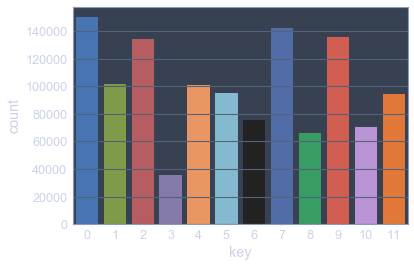

In [15]:
#key - root note
sns.countplot(df.key)

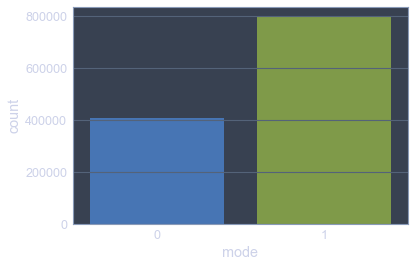

In [16]:
#mode - Major is 1, Minor is 0
sns.countplot(df['mode'])

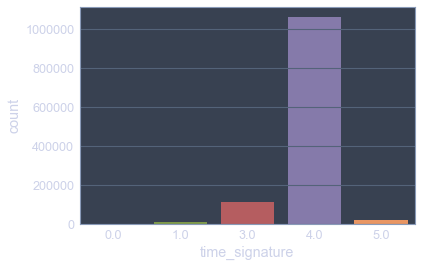

In [17]:
sns.countplot(df['time_signature'])

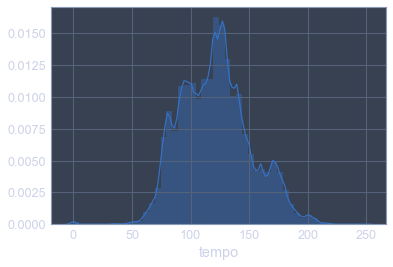

In [18]:
sns.distplot(df['tempo'])

#### Abstract Features

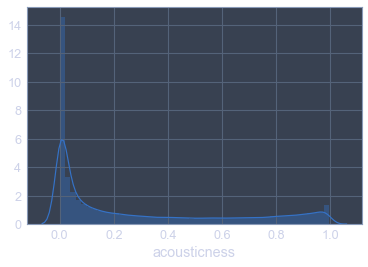

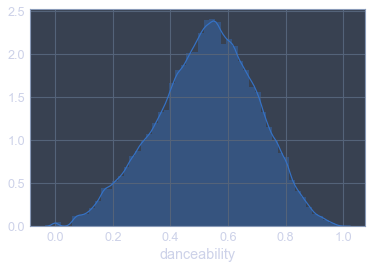

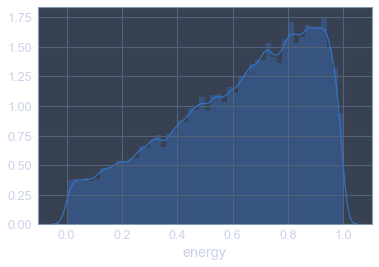

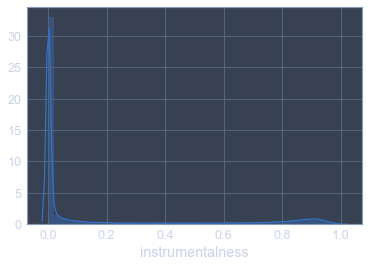

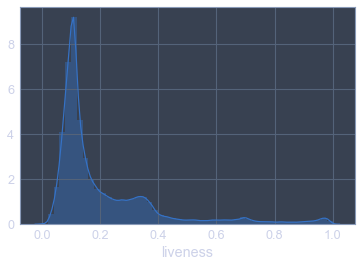

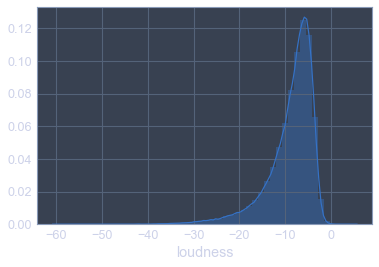

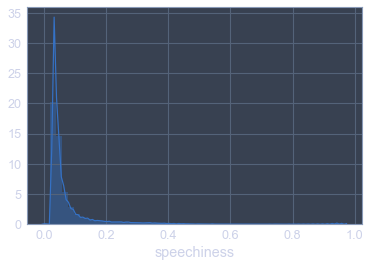

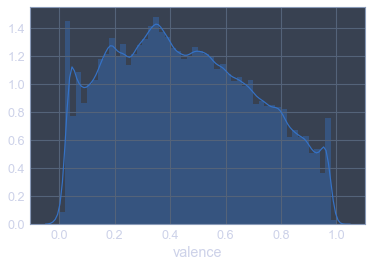

In [19]:
for att in abstractness:
    sns.distplot(df[att].dropna())
    plt.show() 

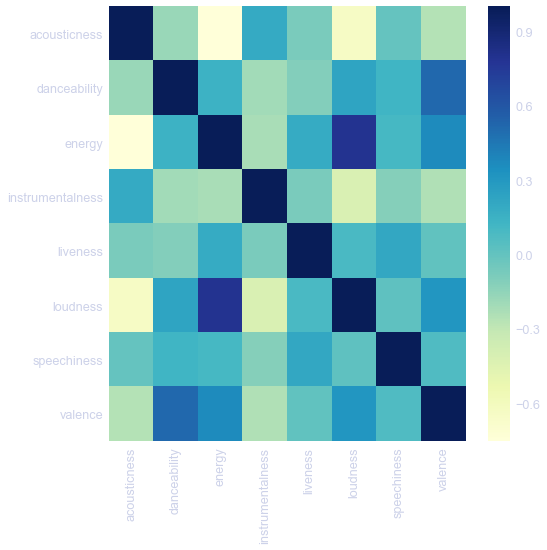

In [20]:
plt.figure(figsize=(8,8))
sns.heatmap(df[abstractness].corr(), cmap='YlGnBu')
plt.show()

## Scaling
Yeo-Johnson Transformation
- https://academic.oup.com/biomet/article-abstract/87/4/954/232908

In [21]:
y_j = PowerTransformer(method='yeo-johnson').fit(df[abstractness])

acousticness


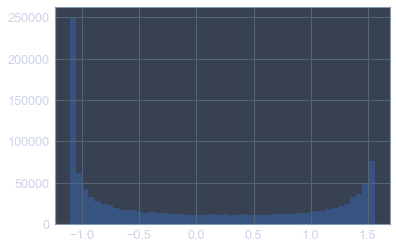

danceability


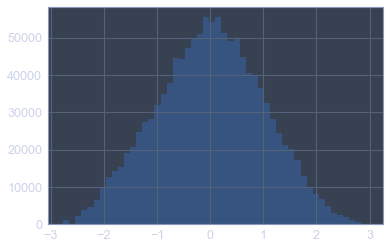

energy


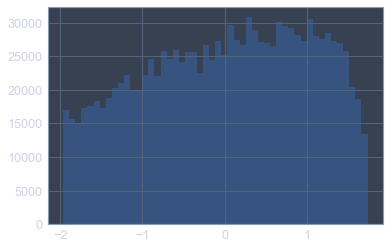

instrumentalness


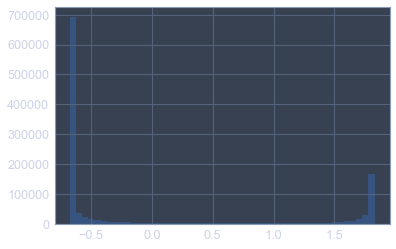

liveness


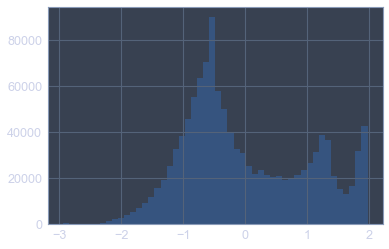

loudness


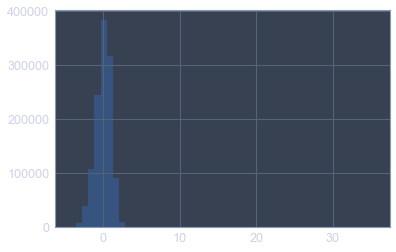

speechiness


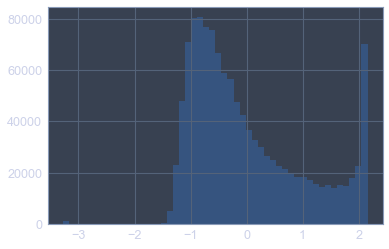

valence


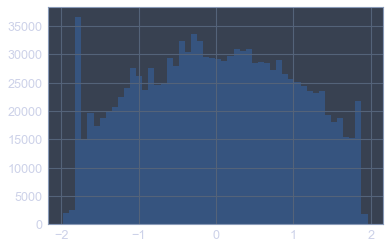

In [22]:
for i in range(0,8):
    sns.distplot(
        y_j.transform(df[abstractness])[:,i],
        kde=False,
    )
    print(abstractness[i])
    plt.show()

## Correlation Heatmap Before/After Transformation

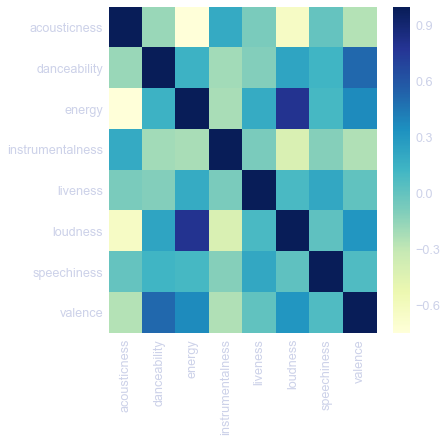

In [23]:
#Before
plt.figure(figsize=(6,6))
sns.heatmap(df[abstractness].corr(), cmap='YlGnBu')
plt.show()

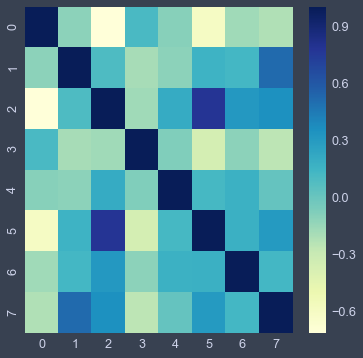

In [29]:
#After
plt.figure(figsize=(6,6))
sns.heatmap(pd.DataFrame(y_j.transform(df[abstractness])).corr(), cmap='YlGnBu')
plt.show()

## PCA
- https://plot.ly/python/v3/3d-line-plots/
- Example Code: https://plot.ly/~btsui/23//#code


In [45]:
pca = PCA(n_components=3)
#pca.fit(df[abstractness])
std_scaler = StandardScaler()
std_scaler.fit(
    y_j.transform(
        df[abstractness]
    )
)

pca.fit(std_scaler.transform(y_j.transform(df[abstractness])))

def do_pca(data,connected=False):
    X = std_scaler.transform(y_j.transform(data[abstractness]))
    x,y,z = pca.transform(X).T
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers' if connected == False else 'lines+markers', #lines+markers for connected
        text=data['search_string'],
        marker=dict(
            size=5,
            color=z,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8,
        ),
        line=dict(
        color='#000000',
        width=1
    )
    )])
    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene={
            'xaxis_title':'PC0',
            'yaxis_title':'PC1',
            'zaxis_title':'PC2'
        }
    ),
    fig.show() 

In [46]:
do_pca(df.sample(frac=0.001))

In [68]:
do_pca(df.loc[df.index[3000][0]][0:12],connected=True)

In [62]:
df.index.to_series().nunique()

1202916

# Next Steps
- get it on SageMaker
- train model
- build pipeline
... and that's it